IMPORTS:

In [1]:
import numpy as np
import os
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy.signal import detrend
import pandas as pd
from torch.utils.data import random_split
from sklearn.preprocessing import MinMaxScaler

MY DATASET.CLASS:

In [2]:
class ECGData(Dataset):
    def __init__(self):
        rwma_labels = np.loadtxt(
            "/home/ngsci/datasets/silent-cchs-ecg/csv/rwma-outcomes.csv",
            delimiter=",",
            dtype=np.float32,
            skiprows=1,
        )
        npy_filepath = "/home/ngsci/datasets/silent-cchs-ecg/npy"
        dir_list = os.listdir(npy_filepath)
        npy_arrays = []
        for each in dir_list:
            file = f"{npy_filepath}/{each}"
            npy_arrays.append(np.load(file))
        stacked = np.stack(npy_arrays, axis=1)
        self.X = torch.from_numpy(stacked)
        self.y = torch.from_numpy(rwma_labels[:, 1:])

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return (self.X[idx, :, :, :], self.y[idx])


DATA SPLIT / PREPROCESS / PREPARE / INITIATE...

In [3]:

data = ECGData() #instanz of above Custom Class

###  DATA SPLIT FUNCKTION and INIT.
### 

def split_data(data):
    indexRange = torch.arange(0, len(data))
    train_size = int(0.8 * len(data))
    train_split, test_split = random_split(
        indexRange, [train_size, len(data) - train_size]
    )
    X_train = data[train_split][0].squeeze(dim=2)
    X_test = data[test_split][0].squeeze(dim=2)
    y_train = data[train_split][1]
    y_test = data[test_split][1]
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = split_data(data)


## Data NORMALIZATION
##
def preprocess_data(X_train, X_test):
    # Min-max scaling
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(
        X_train.reshape(-1, X_train.shape[-1])
    ).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(
        X_test.shape
    )

    return X_train_scaled, X_test_scaled


X_train_preprocessed, X_test_preprocessed = preprocess_data(X_train, X_test)


In [4]:
X_train = torch.tensor(
    X_train_preprocessed[:, :, :5000], dtype=torch.float32, requires_grad=False
)
X_test = torch.tensor(
    X_test_preprocessed[:, :, :5000], dtype=torch.float32, requires_grad=False
)
y_train = torch.tensor(y_train[:5000], requires_grad=False)
y_test = torch.tensor(y_test[:5000], requires_grad=False)


train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

for inputs, targets in train_loader:
    print(inputs, targets)
    break

tensor([[[0.4062, 0.5201, 0.4879,  ..., 0.6236, 0.6238, 0.6235],
         [0.3829, 0.5008, 0.4670,  ..., 0.6168, 0.6167, 0.6167],
         [0.4070, 0.5204, 0.4880,  ..., 0.6204, 0.6207, 0.6209],
         ...,
         [0.3845, 0.5014, 0.4675,  ..., 0.6059, 0.6056, 0.6060],
         [0.3766, 0.4958, 0.4617,  ..., 0.6124, 0.6119, 0.6121],
         [0.3779, 0.4967, 0.4628,  ..., 0.6117, 0.6116, 0.6117]]]) tensor([[0.]])


/tmp/ipykernel_212/2556358870.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train[:5000], requires_grad=False)
/tmp/ipykernel_212/2556358870.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test[:5000], requires_grad=False)


CNN MODEL CLASS & Instance INIT.:

In [5]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(12, 32, kernel_size=3)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 2499, 50)
        self.fc2 = nn.Linear(50, 50)
        self.fc3 = nn.Linear(50, 50)
        self.fc4 = nn.Linear(50, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        x = self.sigmoid(x)
        return x


# Create an instance of the model
cnn_model = CNNModel()

Hyperparameters & Train-loop:


In [ ]:
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss_history.append(loss.item())

    # Calculate loss on the validation set
    with torch.no_grad():
        val_loss = 0
        total = 0
        for inputs, targets in test_loader:
            outputs = cnn_model(inputs)
            val_loss += criterion(outputs, targets).item()
            total += 1
        val_loss /= total
        val_loss_history.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

Epoch [1/10], Loss: 0.0647, Val Loss: 0.3118
Epoch [2/10], Loss: 0.1465, Val Loss: 0.3140
Epoch [3/10], Loss: 0.0925, Val Loss: 0.3049
Epoch [4/10], Loss: 0.0730, Val Loss: 0.3075
Epoch [5/10], Loss: 0.1290, Val Loss: 0.3084
Epoch [6/10], Loss: 0.1045, Val Loss: 0.3039
Epoch [7/10], Loss: 0.0702, Val Loss: 0.3087
Epoch [8/10], Loss: 0.1095, Val Loss: 0.3050
Epoch [9/10], Loss: 0.1372, Val Loss: 0.3108


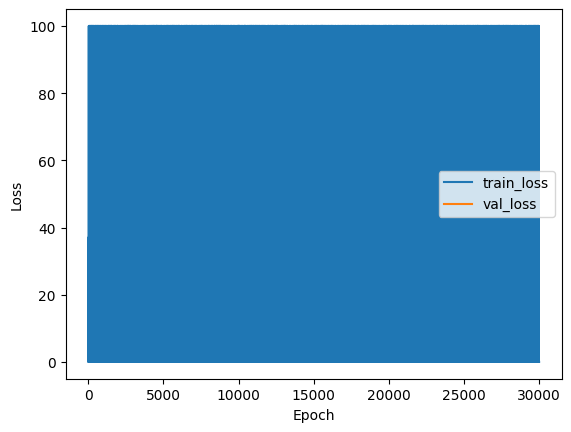

In [7]:
###
### Some Plotting

# Plot the loss curve
plt.plot(train_loss_history, label="train_loss")
plt.plot(val_loss_history, label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
